In [17]:
# STEP 1: IMPORT LIBRARIES

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from lime.lime_tabular import LimeTabularExplainer
from anchor import anchor_tabular
import openai
import matplotlib.pyplot as plt

# STEP 2: LOAD AND PREPARE THE CARDIO DATASET

# Load dataset
df = pd.read_csv("cardio_train.csv", sep=';')

# Convert age from days → years
df['age'] = (df['age'] / 365).round().astype(int)

print("Dataset shape:", df.shape)
print(df.head())

# Separate features (X) and target (y)
X = df.drop(columns=['cardio', 'id'])
y = df['cardio']

Dataset shape: (70000, 13)
   id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0   50       2     168    62.0    110     80            1     1      0   
1   1   55       1     156    85.0    140     90            3     1      0   
2   2   52       1     165    64.0    130     70            3     1      0   
3   3   48       2     169    82.0    150    100            1     1      0   
4   4   48       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [5]:
# BASIC MISSING VALUE CHECKS
print("\nTotal missing values in the dataset:")
print(df.isnull().sum().sum())

print("\nMissing values per column:")
print(df.isnull().sum())


Total missing values in the dataset:
0

Missing values per column:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64



Class distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64

Class proportions (%):
cardio
0    50.03
1    49.97
Name: count, dtype: float64


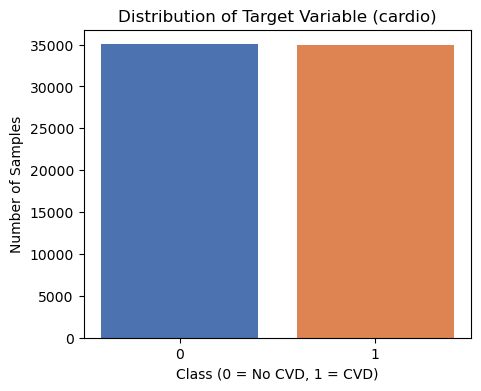

In [7]:
# CHECK FOR CLASS IMBALANCE

# Count each class
class_counts = y.value_counts()

# Display counts and proportions
print("\nClass distribution:")
print(class_counts)
print("\nClass proportions (%):")
print(round((class_counts / len(y)) * 100, 2))

# Visualize class balance
plt.figure(figsize=(5,4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['#4c72b0', '#dd8452'])
plt.title("Distribution of Target Variable (cardio)")
plt.xlabel("Class (0 = No CVD, 1 = CVD)")
plt.ylabel("Number of Samples")
plt.show()

In [9]:
# Drop ID column if it exists
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Define features and label
X = df.drop('cardio', axis=1)
y = df['cardio']

# Optional: scale numerical features for LIME/Anchors stability
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#STEP 3: TRAIN XGBOOST MODEL

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.7336428571428572
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      7004
           1       0.75      0.69      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.73     14000
weighted avg       0.74      0.73      0.73     14000



PermutationExplainer explainer: 14001it [12:54, 17.95it/s]                                                             
C:\Users\awoke\AppData\Local\Temp\ipykernel_28712\3693196033.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


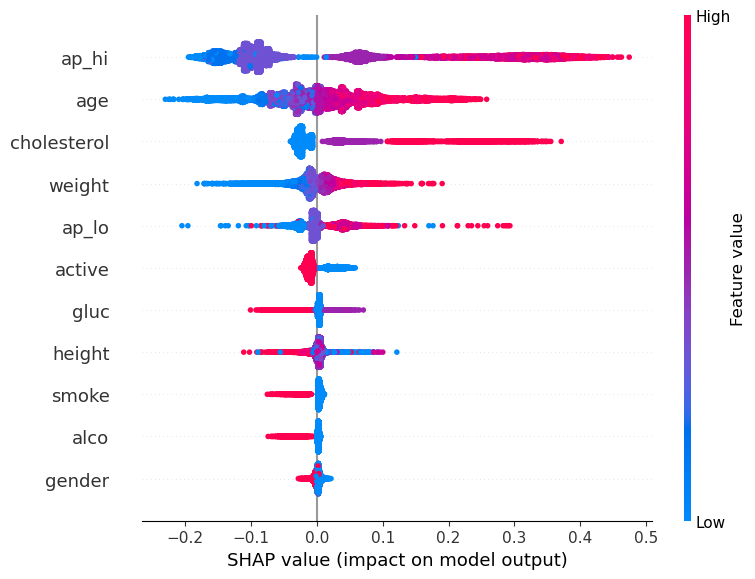

In [23]:
# STEP 4A: SHAP EXPLANATIONS

import shap
import xgboost as xgb

# Get Booster from trained model
booster = model.get_booster()

# Define a wrapper for booster predictions
def booster_predict(data_as_df):
    # Ensure feature names are a list of strings
    feature_list = list(data_as_df.columns)
    dmatrix = xgb.DMatrix(data_as_df, feature_names=feature_list)
    return booster.predict(dmatrix)

# Create SHAP Explainer
explainer_shap = shap.Explainer(booster_predict, X_train)

# Compute SHAP values for test data
shap_values = explainer_shap(X_test)

# Global summary plot
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)

In [25]:
#SHAP summary values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print(importance_df.head(10))

        Feature  Mean_Abs_SHAP
4         ap_hi       0.159233
0           age       0.058822
6   cholesterol       0.045805
3        weight       0.024554
5         ap_lo       0.020500
10       active       0.015009
7          gluc       0.006633
2        height       0.006545
8         smoke       0.006418
9          alco       0.004370


In [27]:
shap.plots.force(shap_values[1:100])

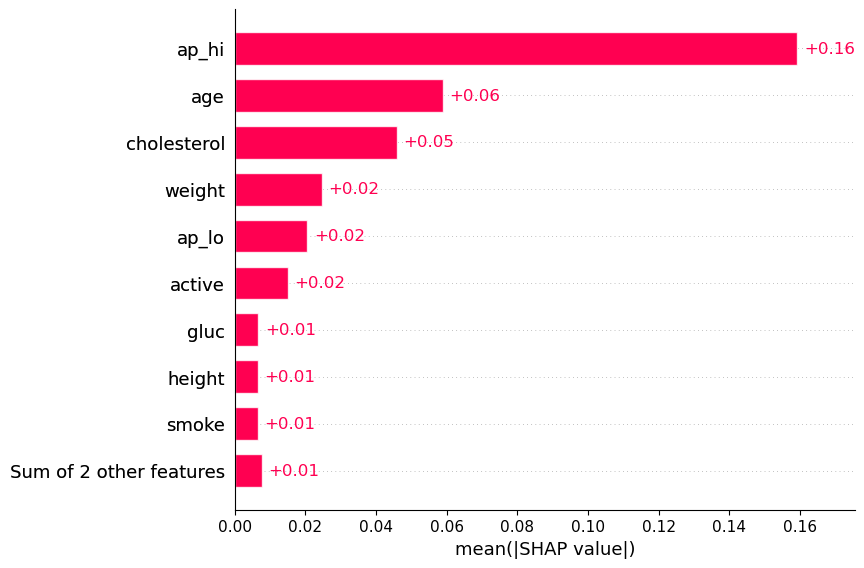

In [29]:
shap.plots.bar(shap_values)

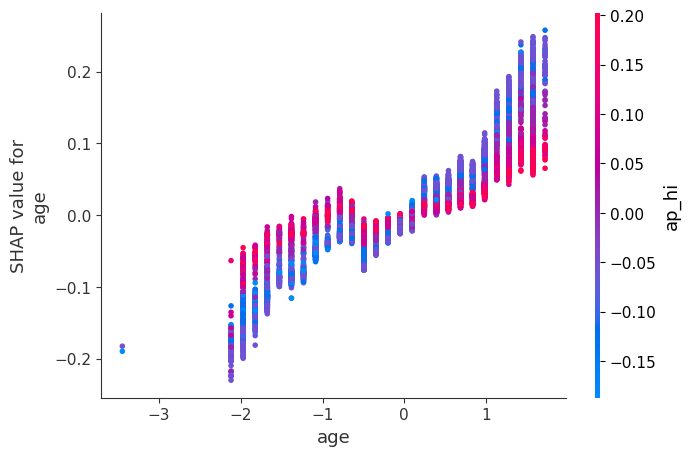

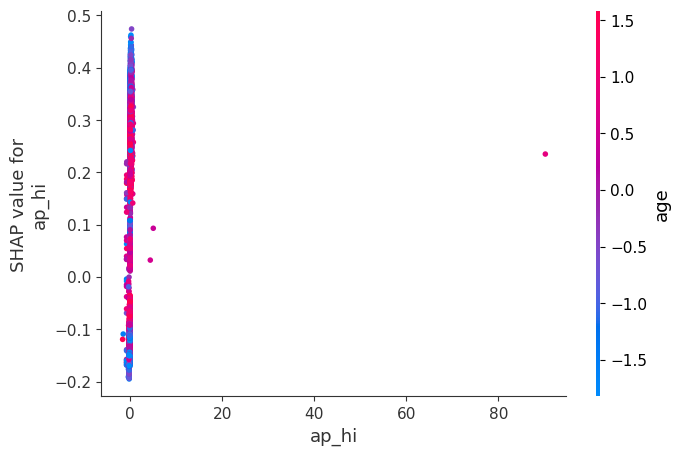

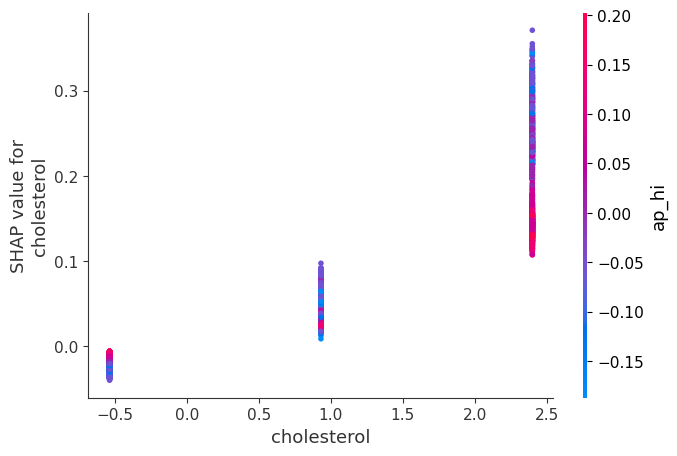

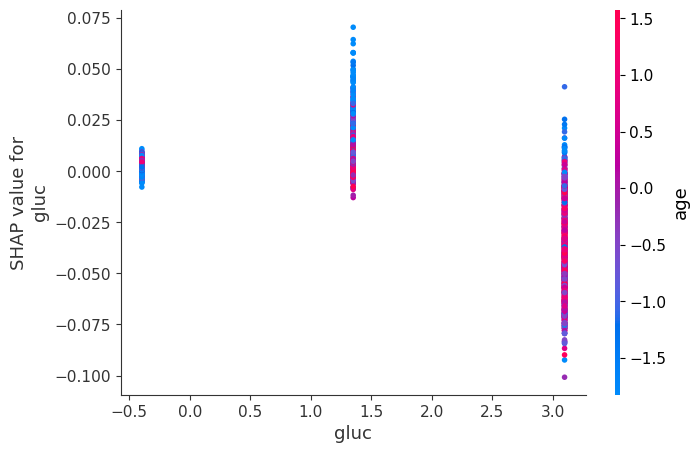

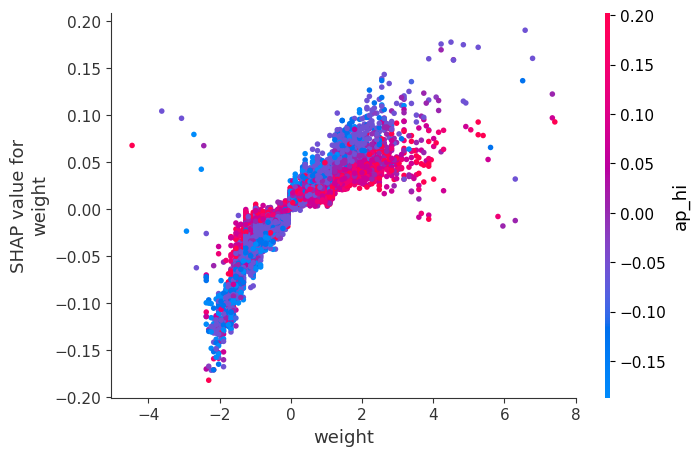

In [31]:
for feature in ["age", "ap_hi", "cholesterol", "gluc", "weight"]:
    shap.dependence_plot(feature, shap_values.values, X_test)

In [33]:
# Patient index
i = 12000
patient_data = X.iloc[X_test.index[i]]
print(patient_data)

age             40.0
gender           1.0
height         158.0
weight          70.0
ap_hi          110.0
ap_lo           90.0
cholesterol      1.0
gluc             1.0
smoke            0.0
alco             0.0
active           1.0
Name: 39657, dtype: float64


In [35]:
# Force plot

#Model prediction
patient_pred_prob = model.predict_proba(X_test.iloc[i:i+1])[0,1]
patient_pred_label = "Disease (CVD)" if patient_pred_prob >= 0.5 else "No Disease"

print(f"Patient {i} → Predicted Probability: {patient_pred_prob*100:.2f}%")
print(f"Predicted Class: {patient_pred_label}")

# Enable JS for interactive plots
shap.initjs()

# Force plot for one patient
shap.plots.force(shap_values[i])


Patient 12000 → Predicted Probability: 14.92%
Predicted Class: No Disease


<Figure size 1000x300 with 0 Axes>

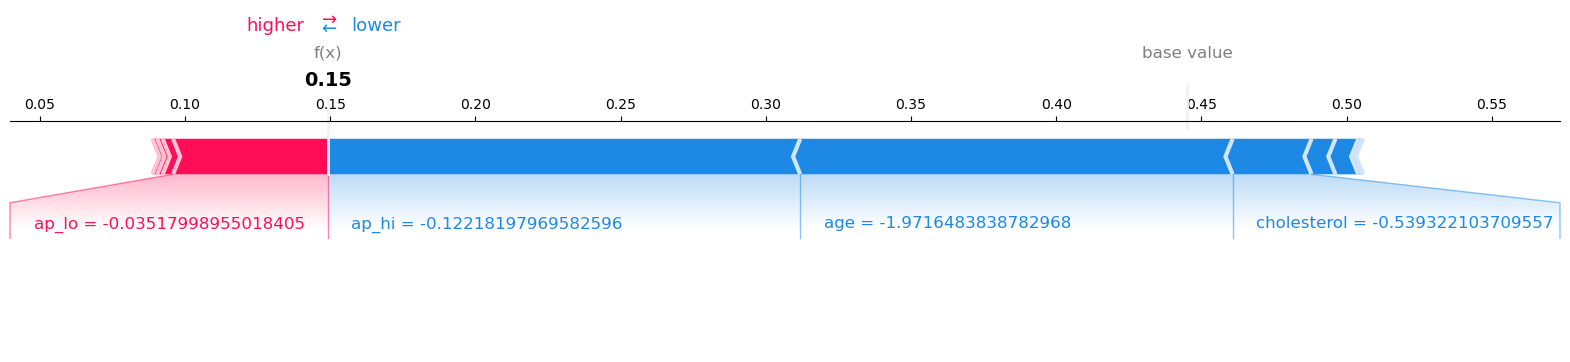

In [37]:
import matplotlib.pyplot as plt
import shap

# Create figure FIRST
plt.figure(figsize=(10, 3))

# Draw SHAP force plot (static)
shap.force_plot(
    shap_values.base_values[i],
    shap_values.values[i],
    X_test.iloc[i],
    matplotlib=True
)

# Save figure
plt.savefig("shap_local.png", dpi=300, bbox_inches="tight", facecolor="white")

# Close
plt.close()


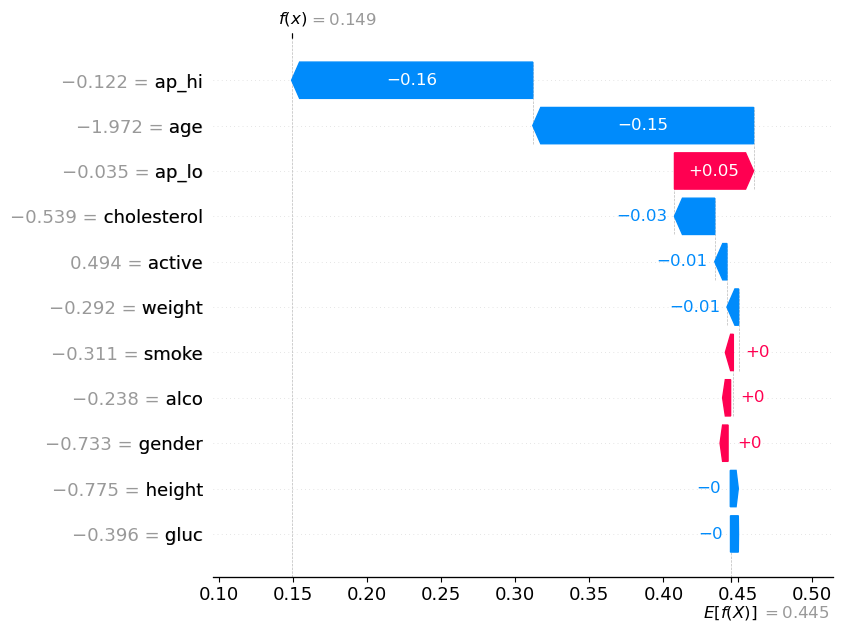

In [39]:
# Waterfall plot
shap.plots.waterfall(shap_values[i], max_display=15)

In [41]:
# TABLE VERSION OF SHAP VALUES
shap_df = pd.DataFrame({
    "Feature": X_test.columns,
    "SHAP_value": shap_values.values[i]
}).sort_values("SHAP_value", ascending=False)

shap_text = shap_df.to_string(index=False)
print(shap_text)

    Feature  SHAP_value
      ap_lo    0.053379
      smoke    0.003561
       alco    0.001841
     gender    0.001708
       gluc   -0.000133
     height   -0.001501
     weight   -0.007879
     active   -0.008228
cholesterol   -0.027176
        age   -0.148922
      ap_hi   -0.162634


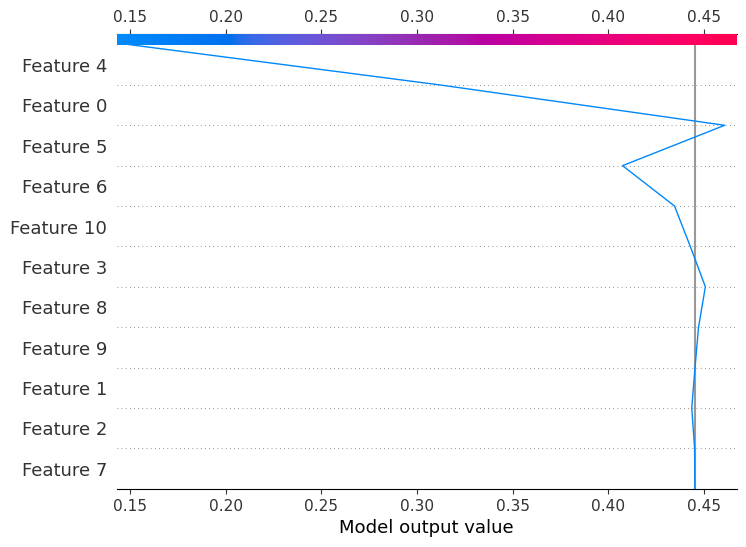

In [43]:
shap.plots.decision(
    shap_values[i].base_values,
    shap_values[i].values
)


In [45]:
# STEP 4B: LIME EXPLANATIONS

patient_instance = X_test.iloc[i]

# Display features
print("Explaining patient", i)
print(patient_instance)
print("\nOriginal (unscaled) data:\n", X.iloc[X_test.index[i]])
print("True label:", y_test.iloc[i])

explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=["No Disease", "Disease"],
    mode="classification"
)

exp_lime = explainer_lime.explain_instance(
    data_row=patient_instance.values,
    predict_fn= model.predict_proba   # make sure this is your XGBoost model
)

exp_lime.show_in_notebook(show_table=True)
lime_text = str(exp_lime.as_list())
print("\nLIME explanation:", lime_text)

Explaining patient 12000
age           -1.971648
gender        -0.733108
height        -0.774565
weight        -0.292150
ap_hi         -0.122182
ap_lo         -0.035180
cholesterol   -0.539322
gluc          -0.395720
smoke         -0.310879
alco          -0.238384
active         0.494167
Name: 39657, dtype: float64

Original (unscaled) data:
 age             40.0
gender           1.0
height         158.0
weight          70.0
ap_hi          110.0
ap_lo           90.0
cholesterol      1.0
gluc             1.0
smoke            0.0
alco             0.0
active           1.0
Name: 39657, dtype: float64
True label: 0



LIME explanation: [('ap_hi <= -0.06', -0.2519146995663452), ('cholesterol <= -0.54', -0.16445070212170368), ('age <= -0.79', -0.11024559944814062), ('-0.09 < ap_lo <= -0.04', 0.07703658584973039), ('alco <= -0.24', 0.039934168799992086), ('smoke <= -0.31', 0.035618069687115075), ('-0.64 < weight <= -0.15', -0.021668403151529188), ('gender <= -0.73', 0.009025655001939376), ('gluc <= -0.40', -0.008041582553123263), ('height <= -0.65', -0.00032785798688209056)]


<Figure size 640x480 with 0 Axes>

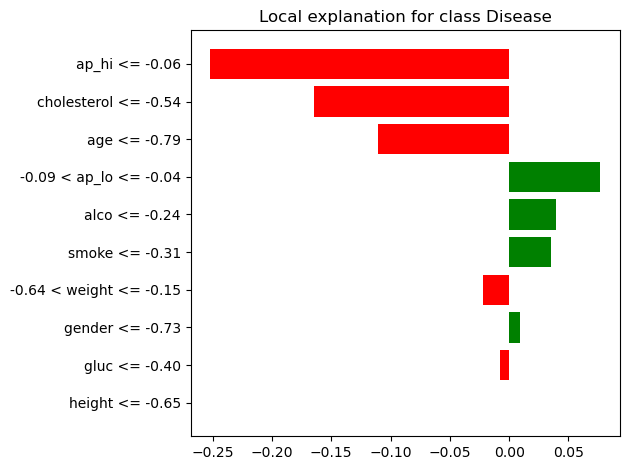

In [47]:
import matplotlib.pyplot as plt
import shap

# LIME summary plot
plt.figure()
fig = exp_lime.as_pyplot_figure()
plt.tight_layout()

In [49]:
import pandas as pd
from IPython.display import display

lime_list = exp_lime.as_list()   # list of (feature, contribution)

lime_df = pd.DataFrame(lime_list, columns=["Feature (condition)", "Contribution"])
display(lime_df)

,Feature (condition),Contribution
0,ap_hi <= -0.06,-0.251915
1,cholesterol <= -0.54,-0.164451
2,age <= -0.79,-0.110246
3,-0.09 < ap_lo <= -0.04,0.077037
4,alco <= -0.24,0.039934
5,smoke <= -0.31,0.035618
6,-0.64 < weight <= -0.15,-0.021668
7,gender <= -0.73,0.009026
8,gluc <= -0.40,-0.008042
9,height <= -0.65,-0.000328


In [51]:
# STEP 4C: ANCHORS EXPLANATIONS

from anchor import anchor_tabular

#Prepare instance to explain
instance = X_test.iloc[i].values.reshape(1, -1)

print(f"\nExplaining patient index {i}")
print(X_test.iloc[i])
print("True Label:", y_test.iloc[i])

#Create explainer
explainer_anchor = anchor_tabular.AnchorTabularExplainer(
    class_names=["No Disease", "Disease"],
    feature_names=X_train.columns.tolist(),
    train_data=X_train.values
)

#Explain the selected patient
exp_anchor = explainer_anchor.explain_instance(
    X_test.iloc[i].values,
    model.predict,
    threshold=0.95     
)

# 5. Show output

anchor_text = "\n".join([
    f"Anchor Rule: {exp_anchor.names()}",
    f"Precision:   {exp_anchor.precision():.3f}",
    f"Coverage:    {exp_anchor.coverage():.3f}"
])

print("\nGenerated Anchor Text:\n", anchor_text)


Explaining patient index 12000
age           -1.971648
gender        -0.733108
height        -0.774565
weight        -0.292150
ap_hi         -0.122182
ap_lo         -0.035180
cholesterol   -0.539322
gluc          -0.395720
smoke         -0.310879
alco          -0.238384
active         0.494167
Name: 39657, dtype: float64
True Label: 0

Generated Anchor Text:
 Anchor Rule: ['ap_hi <= -0.06', 'age <= -0.79', 'cholesterol <= -0.54']
Precision:   0.991
Coverage:    0.156


(0.0, 1.0, 0.0, 1.0)

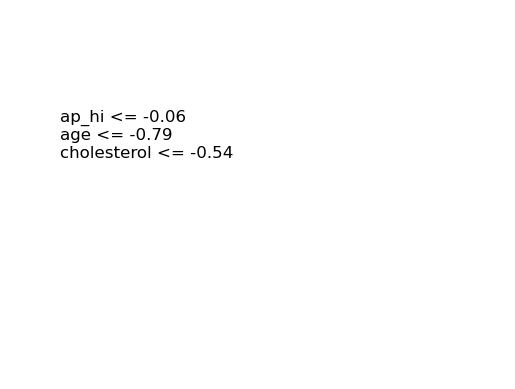

In [53]:
import matplotlib.pyplot as plt
import shap

# Anchors summary plot
plt.figure()
plt.text(0.1, 0.6, "\n".join(exp_anchor.names()), fontsize=12)
plt.axis("off")

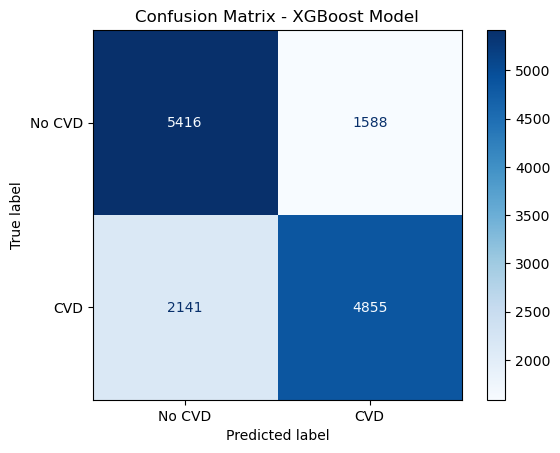

Classification Report:

              precision    recall  f1-score   support

      No CVD       0.72      0.77      0.74      7004
         CVD       0.75      0.69      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.73     14000
weighted avg       0.74      0.73      0.73     14000



In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No CVD", "CVD"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost Model")
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No CVD", "CVD"]))


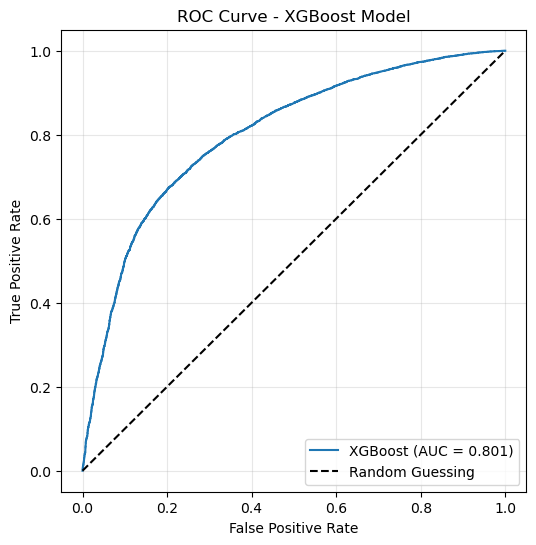

Area Under the Curve (AUC): 0.801


In [57]:
# ROC CURVE AND AUC SCORE

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get model probabilities for positive class (CVD)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Area Under the Curve (AUC): {auc_score:.3f}")


In [ ]:
#STEP 5: LLM-BASED REPORT GENERATION (OpenAI API)

from openai import OpenAI

client = OpenAI(api_key="")

def generate_report(xai_output, audience="doctor"):
    if audience == "doctor":
        prompt = f"""
        Provide a brief clinical interpretation of these XAI results for a doctor (not more than 100 words):
        {xai_output}
        """
    else:
        prompt = f"""
        Briefly explain these XAI results in clear, friendly language for a patient (not more than 100 words):
        {xai_output}
        """

    response = client.chat.completions.create(
        model="gpt-5",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [57]:
#Step 6: Generate Results

# SHAP explanation reports only
method = "SHAP"
result_text = shap_text

print("="*80)
print(f"\n {method} EXPLANATION REPORTS\n")
print("="*80)

# Generate doctor and patient reports separately
doc_report = generate_report(result_text, "doctor")
patient_report = generate_report(result_text, "patient")

print(f"\nDoctor Report ({method}):\n{doc_report}\n")
print(f"\nPatient Report ({method}):\n{patient_report}\n")


 SHAP EXPLANATION REPORTS


Doctor Report (SHAP):
Key drivers for this patient’s prediction are negative SHAP values from systolic BP (ap_hi, -0.162) and age (-0.150), indicating these are lower than the model’s baseline and substantially reduce the predicted outcome. Cholesterol (-0.027) also lowers it. Diastolic BP (ap_lo, +0.053) modestly increases the prediction. Activity (-0.008) and lower weight (-0.007) are slightly protective. Smoking, alcohol, gender, glucose, and height have minimal impact. Overall, negative contributions outweigh positives, so the model’s predicted risk/outcome is below its baseline. Interpretation is relative to the model’s baseline.


Patient Report (SHAP):
These numbers show how each factor pushed your modelled risk up or down. Positive values increase risk; negative values decrease it. For you, systolic blood pressure (ap_hi) and age most strongly lowered the predicted risk; cholesterol also lowered it. Diastolic blood pressure (ap_lo) slightly raised r

In [59]:
# LIME explanation reports only
method = "LIME"
result_text = lime_text

# Convert patient features into text for reporting
patient_info = patient_instance.to_frame(name="Value")
patient_info_str = patient_info.to_string()

# 3️Build a unified text block containing:
full_text_for_report = (
    "PATIENT FEATURE VALUES:\n"
    + patient_info_str
    + "\n\nLIME EXPLANATION:\n"
    + result_text
)
print("="*80)
print(f"\n {method} EXPLANATION REPORTS\n")
print("="*80)

# Generate doctor and patient reports separately
doc_report = generate_report(result_text, "doctor")
patient_report = generate_report(result_text, "patient")

print(f"\nDoctor Report ({method}):\n{doc_report}\n")
print(f"\nPatient Report ({method}):\n{patient_report}\n")


 LIME EXPLANATION REPORTS


Doctor Report (LIME):
Model explanation suggests this patient’s predicted cardiovascular risk is mainly lowered by below-average systolic blood pressure, low cholesterol, and younger age. A mildly elevated diastolic pressure slightly increases risk. Alcohol use and smoking contribute small additional risk. Lower glucose and lower body weight provide minor risk reduction. Gender and height have negligible impact here. Overall, protective effects (especially low systolic BP) outweigh the modest risk-increasing factors, indicating a relatively lower predicted risk in this profile, assuming features reflect current clinical measurements.


Patient Report (LIME):
Here’s how the model weighed your data:

- Biggest risk-lowers: lower top blood pressure (systolic), lower cholesterol, and younger age.
- Small uptick: slightly higher bottom blood pressure (diastolic).
- Very small increases: alcohol and smoking indicators.
- Small risk-lowers: lower glucose and lower

In [61]:
# Anchors explanation reports only
method = "Anchors"
result_text = anchor_text

print("="*80)
print(f"\n {method} EXPLANATION REPORTS\n")
print("="*80)

# Generate doctor and patient reports separately
doc_report = generate_report(result_text, "doctor")
patient_report = generate_report(result_text, "patient")

print(f"\nDoctor Report ({method}):\n{doc_report}\n")
print(f"\nPatient Report ({method}):\n{patient_report}\n")


 Anchors EXPLANATION REPORTS


Doctor Report (Anchors):
This anchor indicates that when standardized systolic blood pressure (ap_hi) is slightly below the cohort mean and age is well below the mean, the model almost always predicts the target class (precision 95.8%). However, this applies to only 17% of patients (coverage). Clinically, younger age and lower SBP are the dominant drivers of this prediction; for older or higher-BP patients, other factors likely drive risk.


Patient Report (Anchors):
Anchor rule (what the model focused on): systolic blood pressure a bit below average and younger age.

What it means:
- When both are true, the model makes a very reliable prediction—about 96% correct (precision 0.958).
- This situation applies to around 17% of patients (coverage 0.170).

In plain terms: For people who are a bit younger and have slightly lower systolic blood pressure, the model tends to give the same, highly trustworthy prediction.



In [33]:
#STEP 7: COMPARISON TABLE

comparison = pd.DataFrame({
    "Method": ["SHAP", "LIME", "Anchors"],
    "Output_Format": ["Feature contribution values", "Local linear approximation", "IF–THEN rules"],
    "Interpretability": ["High (quantitative)", "Medium–High (visual)", "High (logical rules)"],
    "Best_For": ["Global + local explanations", "Local single predictions", "Simple rule-based explanations"]
})
print("\n Comparison of XAI Methods:\n")
display(comparison)


 Comparison of XAI Methods:



,Method,Output_Format,Interpretability,Best_For
0,SHAP,Feature contribution values,High (quantitative),Global + local explanations
1,LIME,Local linear approximation,Medium–High (visual),Local single predictions
2,Anchors,IF–THEN rules,High (logical rules),Simple rule-based explanations


In [35]:
from docx import Document
from docx.shared import Inches

for method, result_text in methods.items():
    doc = Document()
    doc.add_heading(f'{method} Explainable AI Report', level=1)

    # Doctor section
    doc.add_heading('Doctor-Oriented Report', level=2)
    doc_report_text = generate_report(result_text, "doctor")
    doc.add_paragraph(doc_report_text)

    # Patient section
    doc.add_heading('Patient-Oriented Report', level=2)
    patient_report_text = generate_report(result_text, "patient")
    doc.add_paragraph(patient_report_text)

    # Add corresponding figure
    if method == "SHAP":
        doc.add_picture("shap_summary.png", width=Inches(5.5))
    elif method == "LIME":
        doc.add_picture("lime_instance.png", width=Inches(5.5))
    elif method == "Anchors":
        doc.add_picture("anchors_rules.png", width=Inches(5.5))

    output_path = f"{method}_XAI_Report.docx"
    doc.save(output_path)
    print(f"Saved {output_path}")

Saved SHAP_XAI_Report.docx
Saved LIME_XAI_Report.docx
Saved Anchors_XAI_Report.docx
